In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sys.path.append('/n/coxfs01/cechavarria/repos/2p-pipeline/')

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

In [9]:
class struct: pass

opts = struct()
opts.rootdir = '/n/coxfs01/2p-data'
opts.animalid = 'JC105'
opts.session = '20190826'
opts.acquisition = 'FOV1_zoom4p0x'
traceid = 'traces101_s2p'
run = 'scenes_combined'

response_type = 'df'

#filter_crit = 'zscore'
#thresh_list = np.arange(0,4.5,1)

# filter_crit = 'perm_p'
# thresh_list = np.array([1,.01,.001,.0001])

filter_crit = 'simple_tstat'
thresh_list = np.array([0, 2, 3, 4])

# filter_crit = 'split_half_R'
# thresh_list = np.array([0,.6,.7,.8])

if ('norm' in response_type) or ('std' in response_type):
    i1 = findOccurrences(response_type,'_')[-1]
    fetch_data = response_type[i1+1:]
else:
    fetch_data = response_type

#% Set up paths:    
acquisition_dir = os.path.join(opts.rootdir, opts.animalid, opts.session, opts.acquisition)
if 'combined' in run:
    traceid_dir = os.path.join(acquisition_dir, run,'traces',traceid)
else:
    traceid_dir = util.get_traceid_from_acquisition(acquisition_dir, run, traceid)
run_dir = traceid_dir.split('/traces')[0]
trace_arrays_dir = os.path.join(traceid_dir,'files')
paradigm_dir = os.path.join(acquisition_dir, run, 'paradigm')


responses_dir = os.path.join(acquisition_dir, run,'responses',traceid)
data_array_dir = os.path.join(responses_dir, 'data_arrays')

    
if not os.path.exists(os.path.join(responses_dir,'figures')):
    os.makedirs(os.path.join(responses_dir,'figures'))

In [10]:
#open_tilf
resp_array_fn = 'trial_response_array.hdf5'
resp_array_filepath = os.path.join(data_array_dir, resp_array_fn)
resp_grp = h5py.File(resp_array_filepath, 'r')


config_img = resp_grp.attrs['config_img'].astype('int')
config_cond = resp_grp.attrs['config_cond'].astype('int')

cell_rois = resp_grp.attrs['s2p_cell_rois']

curr_slice = 'Slice01'#hard,coding for now

#unpack
response_matrix = np.array(resp_grp['/'.join([curr_slice, 'responses' ,fetch_data])])

filter_crit_matrix_trials = np.array(resp_grp['/'.join([curr_slice, 'responses' ,filter_crit])])

#considering only cell rois
response_matrix = response_matrix[:,:,cell_rois]
ntrials,nconfigs,nrois = response_matrix.shape



if filter_crit == 'zscore':
    filter_crit_matrix_trials = filter_crit_matrix_trials[:,:,cell_rois]
    filter_crit_matrix_mean = np.squeeze(np.mean(filter_crit_matrix_trials,0))
elif filter_crit == 'simple_pval' or filter_crit == 'paired_pval' or filter_crit == 'perm_p' or 'stat' in filter_crit:
    filter_crit_matrix_mean = filter_crit_matrix_trials[:,cell_rois]
elif filter_crit == 'split_half_R':
    filter_crit_matrix_mean = filter_crit_matrix_trials[cell_rois]

resp_grp.close()



In [11]:
nreps = 100
split_size_list = np.arange(int(np.floor(ntrials/2)))+1#np.array([4,8,12])
active_count= np.zeros((split_size_list.size,thresh_list.size,nreps))

R_mean_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_max_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_min_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_cells = np.ones((split_size_list.size,thresh_list.size,nreps,nrois))*np.nan


for rep in range(nreps):
    for split_idx,split_size in enumerate(split_size_list):
      #  rep = 0
      #  split_idx = 0
      #  split_size = 30

        #randomly split
        rand_trials = np.random.permutation(ntrials)
        half1 = response_matrix[rand_trials[0:split_size]]
        half2 = response_matrix[rand_trials[split_size:2*split_size]]

        #get mean response across trials
        half1_mean = np.squeeze(np.mean(half1,0))
        half2_mean = np.squeeze(np.mean(half2,0))
        for thresh_idx,filter_thresh in enumerate(thresh_list):

        #     thresh_idx = 0
        #     filter_thresh = 0

            if filter_crit == 'zscore' or 'tstat' in filter_crit:
                thresh = filter_thresh
                thresh_matrix = filter_crit_matrix_mean>thresh
            elif filter_crit == 'simple_pval' or filter_crit == 'paired_pval' or filter_crit == 'perm_p':
                thresh = filter_thresh
                thresh_matrix = np.logical_and(filter_crit_matrix_mean<thresh,filter_crit_matrix_mean>0)
            elif filter_crit == 'split_half_R':
                thresh = filter_thresh
                thresh_matrix= filter_crit_matrix_mean>thresh
                thresh_matrix = np.expand_dims(thresh_matrix,0)
                thresh_matrix = np.tile(thresh_matrix,(nconfigs,1))

            filter_matrix = np.ones((thresh_matrix.shape))*np.nan
            active_rois_per_config = np.nansum(thresh_matrix,1)
            for ridx in range(nrois):
                for idx in range(0,thresh_matrix.shape[0],3):
                        if np.sum(thresh_matrix[idx:idx+3,ridx])>0:
                            filter_matrix[idx:idx+3,ridx] = 1
            active_cell_idx = np.nansum(filter_matrix,0)>0
            num_active_rois = np.nansum(np.nansum(filter_matrix,0)>0)
            active_count[split_idx,thresh_idx,rep] = num_active_rois

            #select subset of cells active with current threshold
            half1_mean_sub = half1_mean[:,active_cell_idx]
            half2_mean_sub = half2_mean[:,active_cell_idx]

            #get split-half correlation value per cell
            for ridx in range(num_active_rois):
                R_tmp = np.corrcoef(np.squeeze(half1_mean_sub[:,ridx]),np.squeeze(half2_mean_sub[:,ridx]))
                R_cells[split_idx,thresh_idx,rep,ridx] = R_tmp[0,1]
            #get some stats on distribution
            R_mean_tmp[split_idx,thresh_idx,rep] = np.nanmean(R_cells[split_idx,thresh_idx,rep,:],0)
            R_max_tmp[split_idx,thresh_idx,rep] = np.nanmax(R_cells[split_idx,thresh_idx,rep,:],0)
            R_min_tmp[split_idx,thresh_idx,rep] = np.nanmin(R_cells[split_idx,thresh_idx,rep,:],0)

In [56]:
R_cells.shape

(60, 4, 100, 146)

In [57]:
R_cells_mean = np.nanmean(R_cells,2)
R_mean = np.nanmean(R_cells_mean,2)

R_se = np.true_divide(np.nanstd(R_cells_mean,2),np.sqrt(R_cells.shape[2]))

active_frac = active_count/nrois
active_frac_mean = np.mean(active_frac,2)
active_frac_se = np.true_divide(np.std(active_count,2),np.sqrt(nreps))


/home/cesar/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


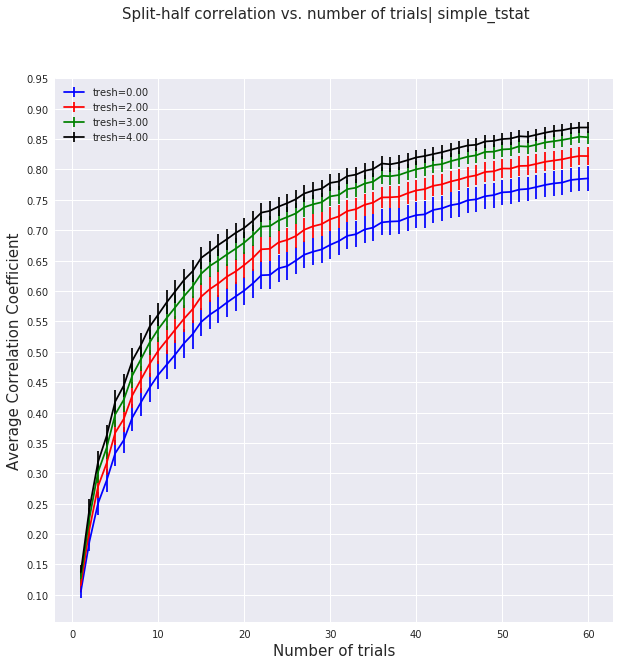

In [58]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(split_size_list,R_mean[:,0],yerr=R_se[:,0],color = 'b',label='tresh=%.02f'%(thresh_list[0]))
plt.errorbar(split_size_list,R_mean[:,1],yerr=R_se[:,1],color = 'r',label='tresh=%.02f'%(thresh_list[1]))
plt.errorbar(split_size_list,R_mean[:,2],yerr=R_se[:,2],color = 'g',label='tresh=%.02f'%(thresh_list[2]))
plt.errorbar(split_size_list,R_mean[:,3],yerr=R_se[:,3],color = 'k',label='tresh=%.02f'%(thresh_list[3]))
plt.ylabel('Average Correlation Coefficient',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Split-half correlation vs. number of trials| %s'%(filter_crit),fontsize = 15)
plt.legend()
axes = plt.gca()
axes.set_yticks(np.arange(.1,1,.05))
fig_fn = '%s_%s_avg_split_half_correlation_vs_ntrials_df_f_thresh_%s.png'%(opts.animalid, opts.session,filter_crit)
plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [ ]:
split_size_list

In [14]:
R_diff = np.diff(R_mean_tmp,axis=0)

R_mean_diff = np.nanmean(R_diff,2)
R_diff_se = np.true_divide(np.nanstd(R_diff,2),np.sqrt(nreps))

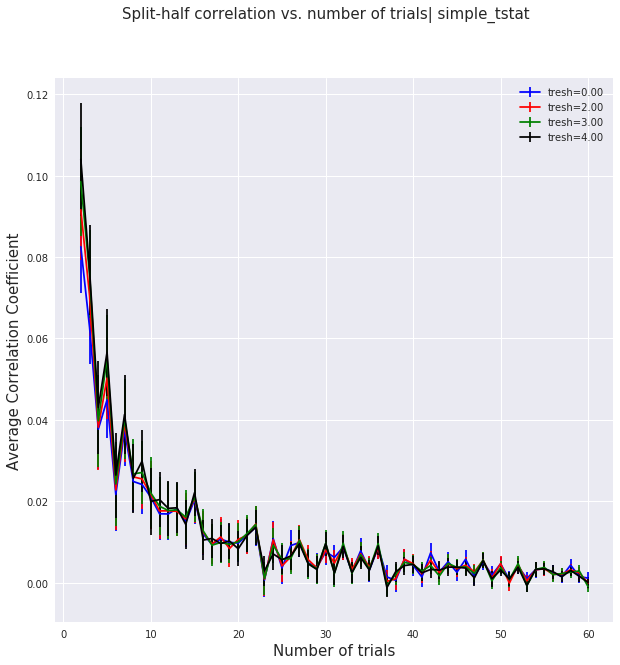

In [61]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(split_size_list[1:],R_mean_diff[:,0],yerr=R_diff_se[:,0],color = 'b',label='tresh=%.02f'%(thresh_list[0]))
plt.errorbar(split_size_list[1:],R_mean_diff[:,1],yerr=R_diff_se[:,1],color = 'r',label='tresh=%.02f'%(thresh_list[1]))
plt.errorbar(split_size_list[1:],R_mean_diff[:,2],yerr=R_diff_se[:,2],color = 'g',label='tresh=%.02f'%(thresh_list[2]))
plt.errorbar(split_size_list[1:],R_mean_diff[:,3],yerr=R_diff_se[:,3],color = 'k',label='tresh=%.02f'%(thresh_list[3]))
plt.ylabel('Average Correlation Coefficient',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Split-half correlation vs. number of trials| %s'%(filter_crit),fontsize = 15)
plt.legend()
axes = plt.gca()
xmin, xmax = axes.get_xlim()
#plt.axhline(y=0.001, linewidth=1, color='k',linestyle = '--')

fig_fn = '%s_%s_diff_avg_split_half_correlation_vs_ntrials_df_f_thresh_%s.png'%(opts.animalid, opts.session,filter_crit)

plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [46]:
R_cells.shape

(60, 4, 100, 146)

In [17]:
R_cells_mean = np.nanmean(R_cells,2)
#R_cells_mean[np.isnan(R_cells_mean)]=0

/home/cesar/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [47]:
R_cells_mean.shape

(60, 4, 146)

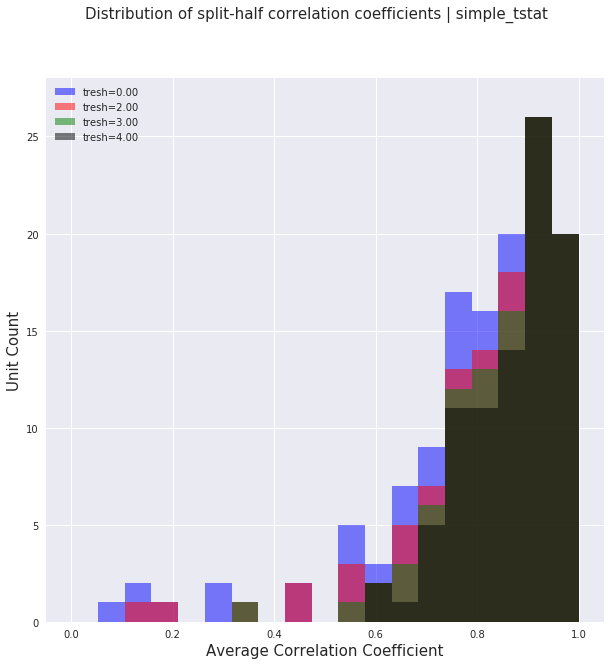

In [27]:
nbins = 20
bins = np.linspace(0,1,nbins)
fig = plt.figure(figsize=(10,10))
size_idx = 59
tmp = R_cells_mean[size_idx,0,:]
plt.hist(tmp[~np.isnan(tmp)],bins,alpha = 0.5, color = 'b',density=False,label='tresh=%.02f'%(thresh_list[0]))
tmp = R_cells_mean[size_idx,1,:]
plt.hist(tmp[~np.isnan(tmp)],bins,alpha = 0.5, color = 'r',density=False,label='tresh=%.02f'%(thresh_list[1]))
tmp = R_cells_mean[size_idx,2,:]
plt.hist(tmp[~np.isnan(tmp)],bins,alpha = 0.5, color = 'g',density=False,label='tresh=%.02f'%(thresh_list[2]))
tmp = R_cells_mean[size_idx,3,:]
plt.hist(tmp[~np.isnan(tmp)],bins,alpha = 0.5, color = 'k',density=False,label='tresh=%.02f'%(thresh_list[3]))
plt.ylabel('Unit Count',fontsize = 15)
plt.xlabel('Average Correlation Coefficient',fontsize = 15)
plt.suptitle('Distribution of split-half correlation coefficients | %s'%(filter_crit),fontsize = 15)
ax = plt.gca()
ax.set_ylim([0,28])
plt.legend(fontsize = 10)
fig_fn = '%s_%s_avg_split_half_correlation_%i_trials_hist_count_df_f_thresh_%s.png'%(opts.animalid, opts.session,split_size_list[size_idx],filter_crit)
plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [42]:
R_cells_mean.shape

(60, 4, 146)

In [54]:
cell_reliable_count = np.sum(R_cells_mean>.85,2)
cell_reliable_frac = cell_reliable_count/float(R_cells_mean.shape[2])

/home/cesar/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


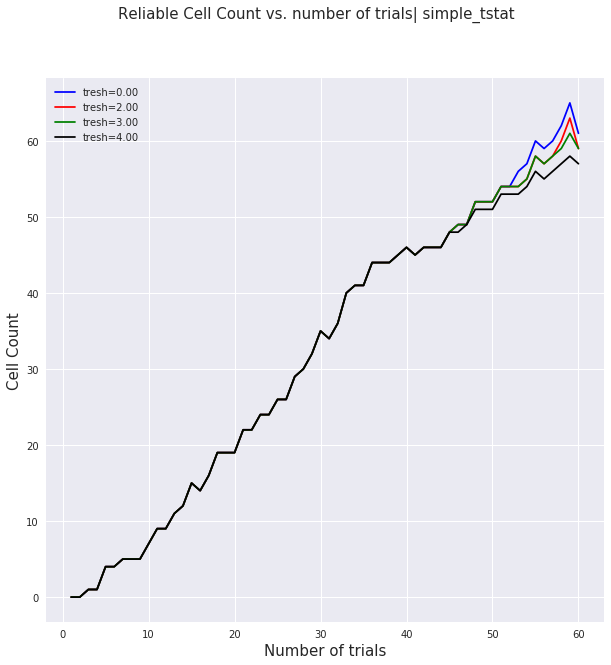

In [55]:
fig = plt.figure(figsize=(10,10))
plt.plot(split_size_list,cell_reliable_count[:,0],color = 'b',label='tresh=%.02f'%(thresh_list[0]))
plt.plot(split_size_list,cell_reliable_count[:,1],color = 'r',label='tresh=%.02f'%(thresh_list[1]))
plt.plot(split_size_list,cell_reliable_count[:,2],color = 'g',label='tresh=%.02f'%(thresh_list[2]))
plt.plot(split_size_list,cell_reliable_count[:,3],color = 'k',label='tresh=%.02f'%(thresh_list[3]))
plt.legend()
plt.ylabel('Cell Count',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Reliable Cell Count vs. number of trials| %s'%(filter_crit),fontsize = 15)
fig_fn = '%s_%s_reliable_cell_count_vs_ntrials.png'%(opts.animalid, opts.session)
#plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

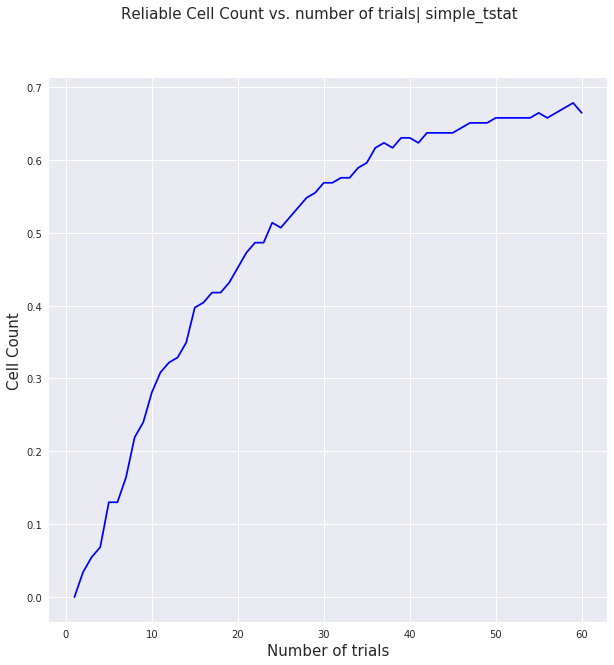

In [38]:
fig = plt.figure(figsize=(10,10))
plt.plot(split_size_list,cell_reliable_frac[:,2],color = 'b',label='tresh=%.02f'%(thresh_list[0]))

plt.ylabel('Cell Count',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Reliable Cell Count vs. number of trials| %s'%(filter_crit),fontsize = 15)
fig_fn = '%s_%s_reliable_cell_fraction_vs_ntrials.png'%(opts.animalid, opts.session)
#plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.plot(active_frac_mean[:,0],'b')
plt.plot(active_frac_mean[:,1],'r')
plt.plot(active_frac_mean[:,2],'g')
plt.plot(active_frac_mean[:,3],'k')
plt.ylabel('Fraction of Active Cells',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Fraction of active cells vs. number of trials',fontsize = 15)
plt.legend(('thresh=0','thresh=1','thresh=2','thresh=3'),fontsize = 10)

In [ ]:
ridx

In [ ]:
#get cell split-half correlation
                    
            active_rois = np.where(half1_rois)[0]
            


            

In [ ]:
#get number of active cells
#for thresh_idx,thresh in enumerate(thresh_list):
thresh_idx = 0
thresh = 1

half1_rois = np.zeros((nrois,))
for ridx in range(nrois):    
    if np.any(half1_zscore_mean[:,ridx]>thresh):
        half1_rois[ridx] = 1
active_rois = np.where(half1_rois)[0]
active_count[split_idx,thresh_idx,rep] = len(active_rois)

half1_mean_sub = half1_mean[:,active_rois].flatten()
half2_mean_sub = half2_mean[:,active_rois].flatten()

R_mat = np.corrcoef(half1_mean_sub,half2_mean_sub)
R_matrix[split_idx,thresh_idx,rep] = R_mat[0,1]

In [ ]:
#consider a config active if at least one of theversion of an image evoked a response above threshol



#figure out some activity details
active_cell_idx = np.nansum(filter_matrix,0)>0
num_active_rois = np.nansum(np.nansum(filter_matrix,0)>0)
frac_active_rois = num_active_rois/float(len(cell_rois))
print('# active rois = %i'%(num_active_rois))
print('frac active rois = %.04f'%(frac_active_rois))

#normalize across configs within cell, if necessary
if 'norm' in response_type:
    norm_response_array = np.empty((nconfigs,nrois))

    for ridx in range(nrois):
        norm_response_array[:,ridx] = mean_response_matrix[:,ridx]/np.nanmax(mean_response_matrix[:,ridx])
    mean_response_matrix = norm_response_array
if 'std' in response_type:#standardise response by z-scoring across configs
    std_response_array = np.empty((nconfigs,nrois))

    for ridx in range(nrois):
        std_response_array[:,ridx] = (mean_response_matrix[:,ridx]-np.nanmean(mean_response_matrix[:,ridx]))/np.nanstd(mean_response_matrix[:,ridx])
    mean_response_matrix = std_response_array

In [ ]:
half1.shape

In [ ]:
R_mean = np.nanmean(R_matrix,2)
R_se = np.true_divide(np.nanstd(R_matrix,2),np.sqrt(nreps))

active_frac = np.mean(active_count,2)/nrois

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(thresh_list,R_mean[9,:],yerr=R_se[9,:],color = 'b')
plt.errorbar(thresh_list,R_mean[19,:],yerr=R_se[19,:],color = 'r')
plt.errorbar(thresh_list,R_mean[29,:],yerr=R_se[29,:],color = 'g')
plt.ylabel('Average Correlation Coefficient',fontsize = 15)
plt.xlabel('Z-score threshold for activity',fontsize = 15)
plt.suptitle('Split-half correlation vs. threshold for activity',fontsize = 15)
plt.legend(('10 trials','20 trials','30 trials'),fontsize = 10)
#plt.legend(('5 trials','10 trials','15 trials'),fontsize = 10)
#plt.legend(('4 trials','8 trials','12 trials'),fontsize = 10)
fig_fn = '20190705_JC097_split_half_correlation_vs_z_score_thresh_df_f.png'
#plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(split_size_list,R_mean[:,0],yerr=R_se[:,0],color = 'b')
plt.errorbar(split_size_list,R_mean[:,2],yerr=R_se[:,2],color = 'r')
plt.errorbar(split_size_list,R_mean[:,4],yerr=R_se[:,4],color = 'g')
plt.errorbar(split_size_list,R_mean[:,8],yerr=R_se[:,8],color = 'k')
plt.ylabel('Average Correlation Coefficient',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Split-half correlation vs. number of trials',fontsize = 15)
plt.legend(('thresh=0','thresh=1','thresh=2','thresh=3'),fontsize = 10)
fig_fn = '20190705_JC097_split_half_correlation_vs_ntrials_df_f.png'
plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [ ]:
#get correlation for each cell individually
thresh_list = np.arange(0,4.5,0.5)
nreps = 100
split_size_list = np.arange(30)+1#np.array([4,8,12])
active_count= np.zeros((split_size_list.size,thresh_list.size,nreps))
R_mean_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_max_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_min_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_cells = np.ones((split_size_list.size,thresh_list.size,nreps,nrois))*np.nan

for rep in range(nreps):
    for split_idx,split_size in enumerate(split_size_list):

        #randomly split
        rand_trials = np.random.permutation(ntrials)
        half1 = response_matrix[rand_trials[0:split_size]]
        half2 = response_matrix[rand_trials[split_size:(2*split_size)]]
        half1_zscore = zscore_matrix[rand_trials[0:split_size]]
        half2_zscore = zscore_matrix[rand_trials[split_size:(2*split_size)]]

        #get mean response across trials
        half1_mean = np.squeeze(np.mean(half1,0))
        half2_mean = np.squeeze(np.mean(half2,0))
        
        half1_zscore_mean = np.squeeze(np.mean(half1_zscore,0))
        half2_zscore_mean = np.squeeze(np.mean(half2_zscore,0))

        #get number of active cells - (threshold by z-score)
        for thresh_idx,thresh in enumerate(thresh_list):

            half1_rois = np.zeros((nrois,))
            
            for ridx in range(nrois):    
                if np.any(half1_zscore_mean[:,ridx]>thresh):
                    half1_rois[ridx] = 1
                    #get cell split-half correlation
                    R_tmp = np.corrcoef(np.squeeze(half1_mean[:,ridx]),np.squeeze(half2_mean[:,ridx]))
                    R_cells[split_idx,thresh_idx,rep,ridx] = R_tmp[0,1]
            active_rois = np.where(half1_rois)[0]
            active_count[split_idx,thresh_idx,rep] = len(active_rois)


            R_mean_tmp[split_idx,thresh_idx,rep] = np.nanmean(R_cells[split_idx,thresh_idx,rep,:],0)
            R_max_tmp[split_idx,thresh_idx,rep] = np.nanmax(R_cells[split_idx,thresh_idx,rep,:],0)
            R_min_tmp[split_idx,thresh_idx,rep] = np.nanmin(R_cells[split_idx,thresh_idx,rep,:],0)

In [ ]:
R_cells_mean = np.nanmean(R_cells,2)

In [ ]:
thresh_list = np.arange(4)
nreps = 1
split_size_list = np.array([15])
split_idx = 0 
split_size = split_size_list[split_idx]
active_count= np.zeros((split_size_list.size,thresh_list.size,nreps))
R_matrix = np.zeros((split_size_list.size,thresh_list.size,nreps))
thresh_lifetime = np.zeros((nrois,))


for rep in range(nreps):

    #randomly split
    rand_trials = np.random.permutation(ntrials)
    half1 = response_matrix[rand_trials[0:split_size]]
    half2 = response_matrix[rand_trials[split_size:(2*split_size)]]
    half1_zscore = zscore_matrix[rand_trials[0:split_size]]
    half2_zscore = zscore_matrix[rand_trials[split_size:(2*split_size)]]

    #get mean response across trials
    half1_mean = np.squeeze(np.mean(half1,0))
    half2_mean = np.squeeze(np.mean(half2,0))

    half1_zscore_mean = np.squeeze(np.mean(half1_zscore,0))
    half2_zscore_mean = np.squeeze(np.mean(half2_zscore,0))

    #get number of active cells - (threshold by z-score)
    for thresh_idx,thresh in enumerate(thresh_list):

        half1_rois = np.zeros((nrois,))
        for ridx in range(nrois):    
            if np.any(half1_zscore_mean[:,ridx]>thresh):
                half1_rois[ridx] = 1
                thresh_lifetime[ridx] = thresh
        active_rois = np.where(half1_rois)[0]
        active_count[split_idx,thresh_idx,rep] = len(active_rois)

        half1_mean_sub = half1_mean[:,active_rois].flatten()
        half2_mean_sub = half2_mean[:,active_rois].flatten()

        R_mat = np.corrcoef(half1_mean_sub,half2_mean_sub)
        R_matrix[split_idx,thresh_idx,rep] = R_mat[0,1]

In [ ]:
thresh_lt_array = np.zeros(half1_mean.shape)

for ridx in range(nrois):
    thresh_lt_array[:,ridx] = thresh_lifetime[ridx] 

In [ ]:
half1_mean_all = half1_mean.flatten()
half2_mean_all = half2_mean.flatten()
thresh_all = thresh_lt_array.flatten()


In [ ]:
thresh_all[idx]

In [ ]:
c_mat = ['b','r','g','k']
fig = plt.figure(figsize=(10,10))
for idx in range(half1_mean.size):
    plt.scatter(half1_mean_all[idx],half2_mean_all[idx],color = c_mat[int(thresh_all[idx])])
plt.ylabel('Df/F',fontsize = 15)
plt.xlabel('Df/F',fontsize = 15)
plt.suptitle('Split-half correlation',fontsize = 15)
#plt.legend(('thresh=0','thresh=1','thresh=2','thresh=3'),fontsize = 10)


fig_fn = '20190621_JC097_sample_split_half_correlation_max_thresh_color.png'
plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [ ]:
thresh_list = np.arange(0.5,4.5,0.5)
nreps = 100
split_size_list = np.array([15])
split_idx = 0 
split_size = split_size_list[split_idx]

half1_count = np.zeros((split_size_list.size,thresh_list.size,nreps))
overlap_count = np.zeros((split_size_list.size,thresh_list.size,nreps))
in1_or2_count = np.zeros((split_size_list.size,thresh_list.size,nreps))
in1_only_count = np.zeros((split_size_list.size,thresh_list.size,nreps))
in2_only_count = np.zeros((split_size_list.size,thresh_list.size,nreps))

active_count= np.zeros((split_size_list.size,thresh_list.size,nreps))


for rep in range(nreps):

    #randomly split
    rand_trials = np.random.permutation(ntrials)
    half1 = response_matrix[rand_trials[0:split_size]]
    half2 = response_matrix[rand_trials[split_size:(2*split_size)]]
    half1_zscore = zscore_matrix[rand_trials[0:split_size]]
    half2_zscore = zscore_matrix[rand_trials[split_size:(2*split_size)]]

    #get mean response across trials
    half1_zscore_mean = np.squeeze(np.mean(half1_zscore,0))
    half2_zscore_mean = np.squeeze(np.mean(half2_zscore,0))

    #get number of active cells - (threshold by z-score)
    for thresh_idx,thresh in enumerate(thresh_list):

        half1_rois = np.zeros((nrois,))
        half2_rois = np.zeros((nrois,))
        for ridx in range(nrois):    
            if np.any(half1_zscore_mean[:,ridx]>thresh):
                half1_rois[ridx] = 1
            if np.any(half2_zscore_mean[:,ridx]>thresh):
                half2_rois[ridx] = 1
        active_rois1 = np.where(half1_rois)[0].tolist()
        active_rois2 = np.where(half2_rois)[0].tolist()
        
        overlap_count[split_idx,thresh_idx,rep] = len(list(set(active_rois1) & set(active_rois2)))
        in1_or2_count[split_idx,thresh_idx,rep] = np.unique(np.array(active_rois1 + active_rois2)).size
        
#         if len(np.where(half1_rois))>0:
#             in1_only[split_idx,thresh_idx,rep] = np.sum(1-half2_rois[np.where(half1_rois)[0]])
            
#         active_count[split_idx,thresh_idx,rep] = len(active_rois)

#         half1_mean_sub = half1_mean[:,active_rois].flatten()
#         half2_mean_sub = half2_mean[:,active_rois].flatten()

#         R_mat = np.corrcoef(half1_mean_sub,half2_mean_sub)
#         R_matrix[split_idx,thresh_idx,rep] = R_mat[0,1]

In [ ]:
tmp = 
print(tmp)

In [ ]:
np.where(half1_rois)[0]

In [ ]:
mean_overlap = np.squeeze(np.mean(overlap_count,2))
mean_overlap_frac = np.squeeze(np.mean(np.true_divide(overlap_count,in1_or2_count),2))
mean_count = np.squeeze(np.mean(in1_or2_count,2))

In [ ]:
plt.plot(thresh_list,mean_overlap,'b')
plt.plot(thresh_list,mean_count,'g')

In [ ]:
plt.plot(thresh_list,mean_overlap_frac,'b')

In [ ]:
print(len(active_rois1))
print(active_rois1)
print(len(active_rois2))
print(active_rois2)
print(len(list(set(active_rois1) & set(active_rois2))))
print(list(set(active_rois1) & set(active_rois2)))
print(len(list(set(active_rois1) - set(active_rois2))))
print(list())

In [ ]:
set(active_rois1) - set(active_rois2)

In [ ]:
response_matrix_zscore.shape

In [ ]:
R_mean = np.mean(R_matrix,1)
R_se = np.true_divide(np.nanstd(R_matrix,1),np.sqrt(nreps))

plt.errorbar(thresh_list,R_mean,yerr=R_se)

In [ ]:
frac_overlap_mean = np.mean(frac_overlap,1)
half1_count_mean = np.mean(half1_count,1)/nrois
half2_count_mean = np.mean(half2_count,1)/nrois

In [ ]:
plt.plot(thresh_list,frac_overlap_mean,'b')

#
plt.plot(thresh_list,half1_count_mean,'r')
plt.plot(thresh_list,half2_count_mean,'g')

In [ ]:

nreps = 10000




